In [1]:
%pip install --no-deps dearprudence==0.2.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datatree import DataTree, open_datatree
from dearprudence import read_params, SimpleRun
import fsspec
from functools import cache
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xarray as xr

In [3]:
PLOT_DIR = '/gcs/impactlab-data/climate/downscaling/paper/'
SCRATCH_PREFIX = f"{os.environ['CIL_SCRATCH_PREFIX']}/{os.environ['JUPYTERHUB_USER']}"
OUTPUT_CITY_SERIES_ZARR = f"{SCRATCH_PREFIX}/toy_cities_error_all_gcms.zarr"
GDPCIR_MODELS = (
    "ACCESS-CM2",
    "ACCESS-ESM1-5",
    "BCC-CSM2-MR",
    "CMCC-ESM2",
    "CMCC-CM2-SR5",
    "CanESM5",
    "EC-Earth3-Veg",
    "EC-Earth3-CC",
    "EC-Earth3",
    "EC-Earth3-AerChem",
    "EC-Earth3-Veg-LR",
    "FGOALS-g3",
    "GFDL-CM4",
    "GFDL-ESM4",
    "HadGEM3-GC31-LL",
    "UKESM1-0-LL",
    "INM-CM4-8",
    "INM-CM5-0",
    "MIROC6",
    "MIROC-ES2L",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
    "NESM3",
    "NorESM2-LM",
    "NorESM2-MM",
)

In [4]:
@cache
def dc6run_parameters() -> list[list[SimpleRun]]:
    """Gets a list of all the project's run metadata from parameter files in repo
    """
    fs = fsspec.filesystem(
        "github",
        org="climateimpactlab",
        repo="downscaleCMIP6",
        branch="master",
    )
    paths = fs.glob("workflows/parameters/*.yaml")
    return [read_params(fs.open(fl)) for fl in paths]


def clean_input_data() -> DataTree:
    """Clean and standardize input data

    This takes around 5-10 minutes to run on my notebook server without dask-distributed.

    Returns
    -------
    DataTree
        A DataTree with data required for error stats, ready for analysis.
        It has nodes for each of the terms we need for the calculation:
        ``y_sim_fut``, ``x_sim_fut``, `y_sim_hist``, ``x_sim_hist``,
        ``x_obs_hist``.
    """
    # Grab all the metadata we need from the runs used in the GDPCIR.
    targets = []
    for fl_params in dc6run_parameters():
        for run in fl_params:
            # NOTE: We only want info from the historical runs that are
            # actually in the GDPCIR release. The historical runs include
            # information for the future SSP experiments we need.
            if run.historical.source_id in GDPCIR_MODELS and run.target == "historical":
                targets.append((run.historical, run.ssp))

    # Use the targets metadata to grab the diagnostic data we need and standardize it into a
    # DataTree for all GCMs.
    all_ds = {
        "y_sim_fut": [],
        "x_sim_fut": [],
        "y_sim_hist": [],
        "x_sim_hist": [],
        "x_obs_hist": [],
    }
    for historical, ssp in targets:
        # Deal with inconsistent diagnostic city files names for
        # precipitation data.
        file_var_name = historical.variable_id
        variable = historical.variable_id
        if variable == "pr":
            variable = "precip"

        # And yes, someone made a mistake and x_sim_hist needs its
        # institution_id from the ssp (not historical) otherwise it
        # will throw an error.
        input_urls = dict(
            y_sim_fut=f'gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{variable}-diagnostics/{ssp.activity_id}/{ssp.institution_id}/{ssp.source_id}/{ssp.experiment_id}/{ssp.member_id}/day/{file_var_name}/v1.1.zarr',
            y_sim_hist=f'gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{variable}-diagnostics/{historical.activity_id}/{historical.institution_id}/{historical.source_id}/{historical.experiment_id}/{historical.member_id}/day/{file_var_name}/v1.1.zarr',
            x_sim_fut=f'gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{variable}-diagnostics/{ssp.activity_id}/{ssp.institution_id}/{ssp.source_id}/{ssp.experiment_id}/{ssp.member_id}/day/{file_var_name}/v1.1.zarr',
            x_sim_hist=f'gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/clean-daily-{variable}-diagnostics/{historical.activity_id}/{ssp.institution_id}/{historical.source_id}/{historical.experiment_id}/{historical.member_id}/day/{file_var_name}/v1.1.zarr',
        )

        for series_name, url in input_urls.items():
            ds = xr.open_zarr(url)
            # Squeeze and reset because have extra bnd and lat,lon coords that
            # make merging difficult later.
            ds = ds.squeeze(drop=True)
            ds = ds.reset_coords(drop=True)
            ds = ds.expand_dims({
                "source_id": [historical.source_id],
            })
            all_ds[series_name].append(ds)

    # Now parse the reference (reanalysis) data.
    series_name = "x_obs_hist"
    for file_var_name in ("pr", "tasmax", "tasmin"):
        variable = file_var_name
        if variable == "pr":
            variable = "precip"
        input_url = f"gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-{variable}-diagnostics/reanalysis/ERA5/F320/{file_var_name}/v1.1.zarr"
        ds = xr.open_zarr(input_url)
        ds = ds.squeeze(drop=True)
        ds = ds.reset_coords(drop=True)
        all_ds[series_name].append(ds)

    dt = DataTree.from_dict({k: xr.merge(v) for k, v in all_ds.items()})
    return dt

In [5]:
dt = clean_input_data()
# Stash in scratch so we don't need to run this a bunch of times while we
# play with the math and plots below.
dt.to_zarr(OUTPUT_CITY_SERIES_ZARR, mode="w")

In [18]:
# Compute errors for cities on cleaned data.
dt = open_datatree(OUTPUT_CITY_SERIES_ZARR, engine="zarr")

# Slice future and historical periods for each of the input series.
fut = slice("2079-12-16","2100-01-15")
hist = slice("1994-12-16","2015-01-15")
for series in ("y_sim_hist", "x_sim_hist", "x_obs_hist"):
    dt[series] = dt[series].sel(time=hist)
for series in ("y_sim_fut", "x_sim_fut"):
    dt[series] = dt[series].sel(time=fut)

# Aggregate across time to dayofyear. Need to do this with
# "map_over_subtree()" because datatree doesn't yet support rolling.
dt = dt.map_over_subtree(
    lambda ds: ds.rolling(dim={"time":31}, center=True).mean().groupby("time.dayofyear").mean()
)

In [19]:
y_dif = dt["y_sim_fut"] - dt["y_sim_hist"]
x_dif = dt["x_sim_fut"] - dt["x_sim_hist"]
y_obs_dif = dt["y_sim_hist"] - dt["x_obs_hist"]

y_ratio = dt["y_sim_fut"] / dt["y_sim_hist"]
x_ratio = dt["x_sim_fut"] / dt["x_sim_hist"]
y_obs_ratio = dt["y_sim_hist"] / dt["x_obs_hist"]

In [20]:
e_trend = np.abs(y_dif - x_dif).median(dim="dayofyear")
e_bias = np.abs(y_obs_dif).median(dim="dayofyear")


# Doing ratios for precipitation, only.
e_trend["pr"] = np.abs(y_ratio / x_ratio).median(dim="dayofyear")["pr"]
e_bias["pr"] = np.abs(y_obs_ratio).median(dim="dayofyear")["pr"]

In [21]:
# Now reformat the stats so we can plot it in seaborn.
all_df = []
for var_name in e_trend.data_vars:
    trend_df = e_trend.ds[var_name].to_pandas()
    trend_df = trend_df.reset_index().melt(id_vars="source_id")
    trend_df["variable"] = var_name
    trend_df["stat_name"] = "Trend Preservation"
    all_df.append(trend_df)

    bias_df = e_bias.ds[var_name].to_pandas()
    bias_df = bias_df.reset_index().melt(id_vars="source_id")
    bias_df["variable"] = var_name
    bias_df["stat_name"] = "Bias Adjustment"
    all_df.append(bias_df)
e_df = pd.concat(all_df)

for c in ("source_id", "city", "variable", "stat_name"):
    e_df[c] = e_df[c].astype("category")

e_df["variable_name"] = e_df["variable"].map(
    {
        "tasmax": "Maximum Temperature",
        "tasmin": "Minimum Temperature",
        "pr": "Precipitation",
    }
)

In [22]:
# Sanity check:
e_df.query("city == 'Miami' and source_id == 'BCC-CSM2-MR'")

,source_id,city,value,variable,stat_name,variable_name
227,BCC-CSM2-MR,Miami,0.580622,pr,Trend Preservation,Precipitation
227,BCC-CSM2-MR,Miami,0.963698,pr,Bias Adjustment,Precipitation
227,BCC-CSM2-MR,Miami,1.924103,tasmax,Trend Preservation,Maximum Temperature
227,BCC-CSM2-MR,Miami,0.030396,tasmax,Bias Adjustment,Maximum Temperature
227,BCC-CSM2-MR,Miami,2.313843,tasmin,Trend Preservation,Minimum Temperature
227,BCC-CSM2-MR,Miami,0.128326,tasmin,Bias Adjustment,Minimum Temperature


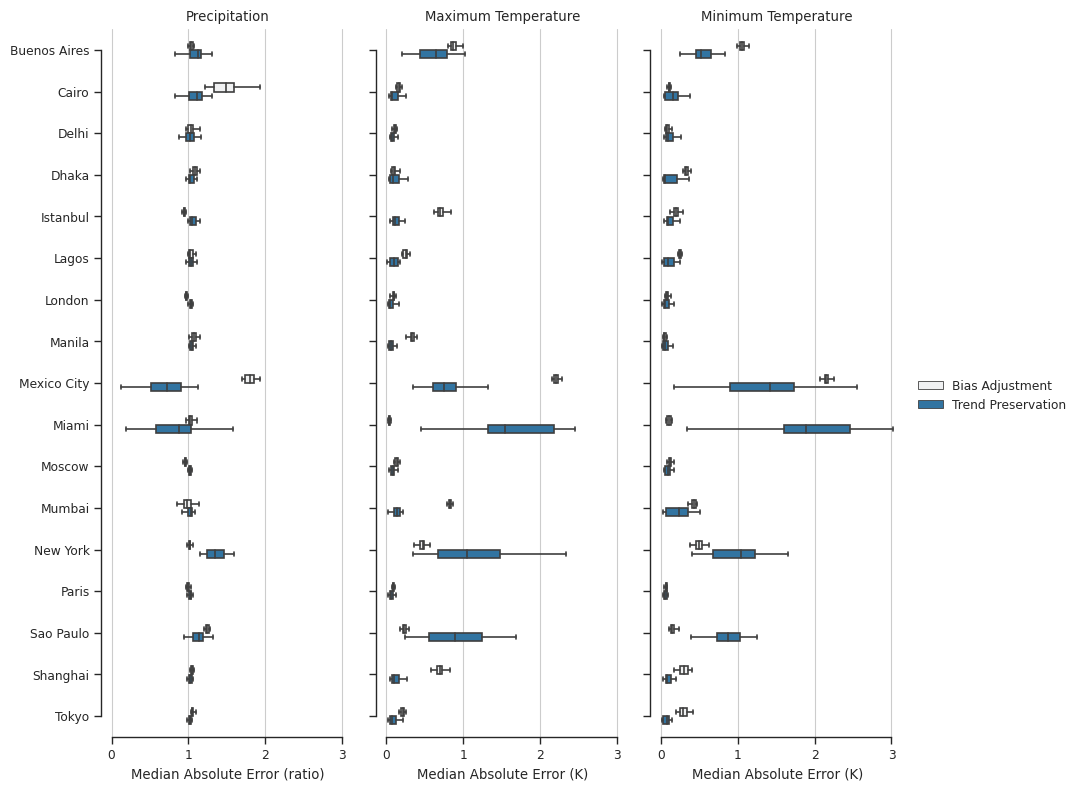

In [23]:
# Plotting the data.
# g = sns.FacetGrid(e_df, col="variable")
# g.map(sns.boxplot, data=e_df, y="value", x="city", hue="source_id")

sns.set_style(style="ticks")
sns.set_context("paper")
g = sns.FacetGrid(
    e_df,
    col="variable_name",
    height=8,
    aspect=0.4,
    legend_out=True,
)
g.map_dataframe(
    sns.boxplot,
    x="value",
    y="city",
    orient="h",
    hue="stat_name",
    showfliers=False,
    width=0.4,
)
g.set_titles(col_template="{col_name}")
g.set_ylabels("")
g.set_xlabels("Median Absolute Error")
g.axes[0, 0].set_xlabel("Median Absolute Error (ratio)")
g.axes[0, 1].set_xlabel("Median Absolute Error (K)")
g.axes[0, 2].set_xlabel("Median Absolute Error (K)")

g.add_legend()
for x, ax in g.axes_dict.items():
    ax.xaxis.grid(True)

g.despine(left=False, trim=True)
g.fig.savefig(os.path.join(PLOT_DIR, 'cities_abs_rel_daily_error.png'),
              bbox_inches='tight', dpi=200)

y-axis:
- rolling 31 day mean for future 20 year period, then daily climatology from that
- subtract the same object but for the historical period
- this will give the daily average "trend", or difference in daily value from the historical to future period for a given city
- plot the `median` of the daily errors
    - try `mean` instead? different quantiles of errors?
- we're comparing the mean "trend" we get from the cleaned data (so it's been regridded) to the final downscaled data to see how well these trends are being maintained
  - try doing quantiles instead of climatology/rolling means?

x-axis:
- rolling 31 day mean for GCM historical period, then daily climatology from that
- subtract the same object from the REFERENCE
- this will give the historcial bias *after adjustment*, so the remaining bias *of the mean* in the historical period

---

Let $\hat{}$ represent a rolling 31-day mean, and $\bar{}$ represent the 20-year mean for each day, then the 20-year daily mean of the rolling 31-day mean of the bias-adjusted historical GCM is $\hat{\bar{y}}^{sim}_{hist}$ and of the reference data is $\hat{\bar{x}}^{obs}_{hist}$. The result is a daily climatology of the smoothed daily time series.


Then the error between the bias-adjusted historical data is the median of daily errors:

$$ e = median(|\hat{\bar{y}}^{sim}_{hist} - \hat{\bar{x}}^{obs}_{hist}|)$$


----
Parking Lot


Rolling mean:
$$ \hat{y_t} = (1/31 \sum_{t=i-15}^{i+15} y_t ) \forall t \in time series$$

Daily average over years:
$$ y^{sim}_{hist} = 1/20 \sum_{t=1995}^{2014} \hat{y_{td}} \forall d \in [1,365] $$
$$ x^{obs}_{hist} = 1/20 \sum_{t=1995}^{2014} \hat{x_{td}} \forall d \in [1,365] $$

Error:
$$ e = |y^{sim}_{hist} - x^{obs}_{hist}|$$

---
RESULTS

How to read:
- points greater than 1:1 line have trend bias that is > historical bias (this is preferred to the reverse)
    - TODO articulate why ----



- Max temperature
    - trends are mostly < 0.25C different. That's great preservation of mean trends
    - there are 3 locations with >1C errors though. Perhaps not bad for a median (of daily) error 100 years later?
- Min temperature
    - very similar story to max temp
- Precip